<a href="https://colab.research.google.com/github/hanifahputrr/ricepaddymapping/blob/main/Rice_Paddy_Mapping_with_CNN_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN-RF**

In [ ]:
! pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 66.3 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from keras.models import Sequential, load_model
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Scheme #1**

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands_merged_new.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)



In [ ]:
# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
#cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

In [ ]:
#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

75/75 [==============================] - 0s 2ms/step


In [ ]:
# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

Training time: 5.557065010070801 seconds
Testing time: 0.05216670036315918 seconds
Total time: 5.60923171043396 seconds
              precision    recall  f1-score   support

         1.0       0.92      0.85      0.88       665
         2.0       0.94      0.97      0.96      1706

    accuracy                           0.94      2371
   macro avg       0.93      0.91      0.92      2371
weighted avg       0.94      0.94      0.94      2371

[[ 564  101]
 [  47 1659]]
Producer accuracy: [0.8481203  0.97245018]
User accuracy: [0.92307692 0.94261364]
Test accuracy: 0.9375790805567271
Overall accuracy: 0.9375790805567271
Kappa coefficient: 0.8414165799727581
Recall: 0.9375790805567271
Precision: 0.9371341279976877
F1 score: 0.9367445181695154


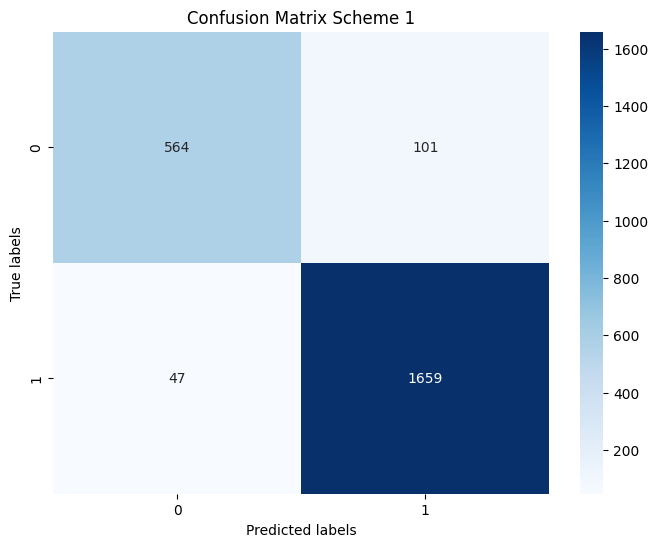

In [ ]:
# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 1')
plt.savefig('S2_Band_CM.png')
plt.show()


In [ ]:
# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands_merged_new.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

9333/9333 [==============================] - 34s 4ms/step


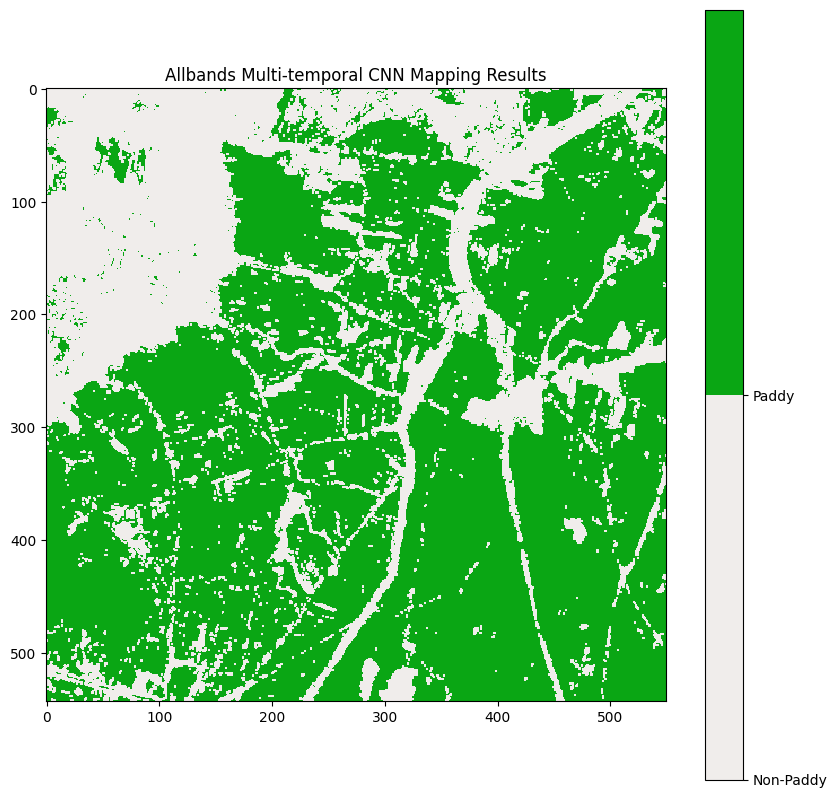

In [ ]:
# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **Scheme #2:**

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+ndvi.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
#cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 4')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+ndvi.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+ndvi.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+ndvi.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **Scheme**

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands_s2_merged.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

75/75 [==============================] - 0s 2ms/step
Training time: 3.360306739807129 seconds
Testing time: 0.05904793739318848 seconds
Total time: 3.4193546772003174 seconds
              precision    recall  f1-score   support

         1.0       0.94      0.88      0.91       665
         2.0       0.95      0.98      0.97      1706

    accuracy                           0.95      2371
   macro avg       0.95      0.93      0.94      2371
weighted avg       0.95      0.95      0.95      2371

[[ 582   83]
 [  35 1671]]
Producer accuracy: [0.87518797 0.97948417]
User accuracy: [0.94327391 0.95267959]
Test accuracy: 0.9502319696330662
Overall accuracy: 0.9502319696330662
Kappa coefficient: 0.8739177615984051
Recall: 0.9502319696330662
Precision: 0.950041555120784
F1 score: 0.9496454866081367


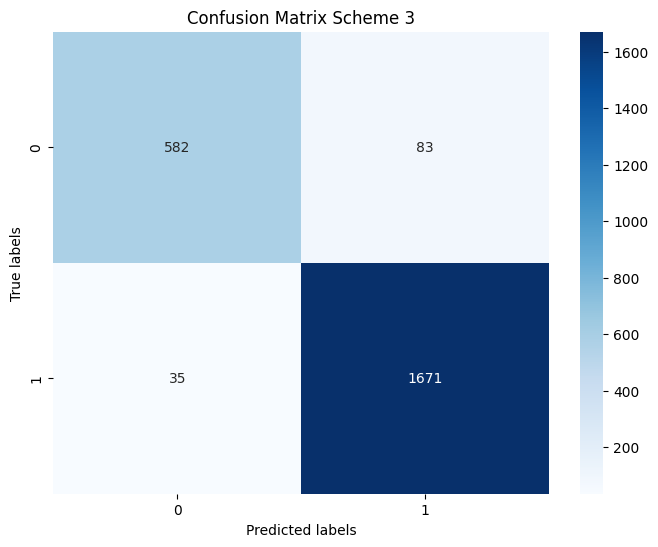

9333/9333 [==============================] - 20s 2ms/step


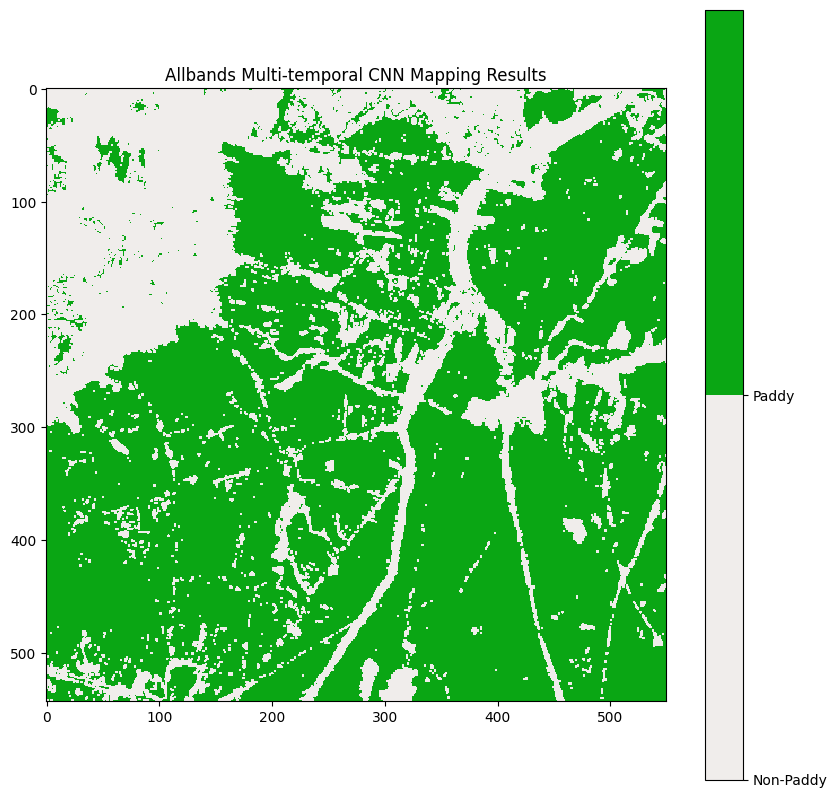

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
#cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 3')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands_s2_merged.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands_s2.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands_s2.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **Scheme 4: all vi**

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allvi_new.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

75/75 [==============================] - 0s 2ms/step
Training time: 2.761667251586914 seconds
Testing time: 0.07554125785827637 seconds
Total time: 2.8372085094451904 seconds
              precision    recall  f1-score   support

         1.0       0.34      0.34      0.34       665
         2.0       0.74      0.75      0.75      1706

    accuracy                           0.63      2371
   macro avg       0.54      0.54      0.54      2371
weighted avg       0.63      0.63      0.63      2371

[[ 225  440]
 [ 432 1274]]
Producer accuracy: [0.33834586 0.74677608]
User accuracy: [0.34246575 0.74329055]
Test accuracy: 0.6322226908477435
Overall accuracy: 0.6322226908477435
Kappa coefficient: 0.0854355292190041
Recall: 0.6322226908477435
Precision: 0.6308702664023615
F1 score: 0.6315400490993723


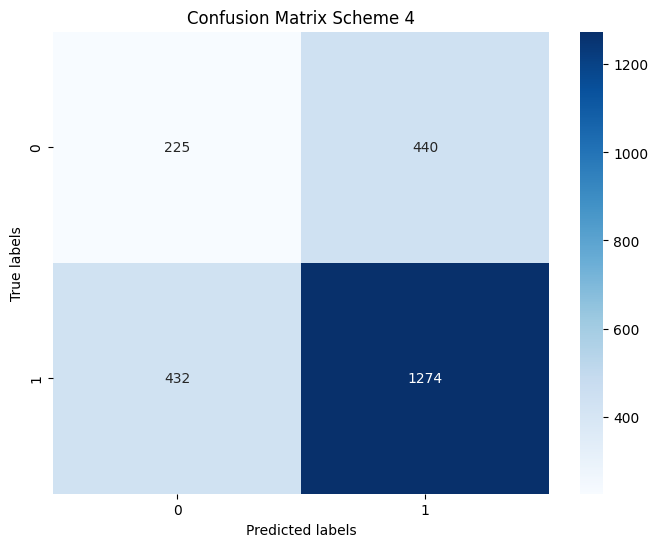

9333/9333 [==============================] - 17s 2ms/step


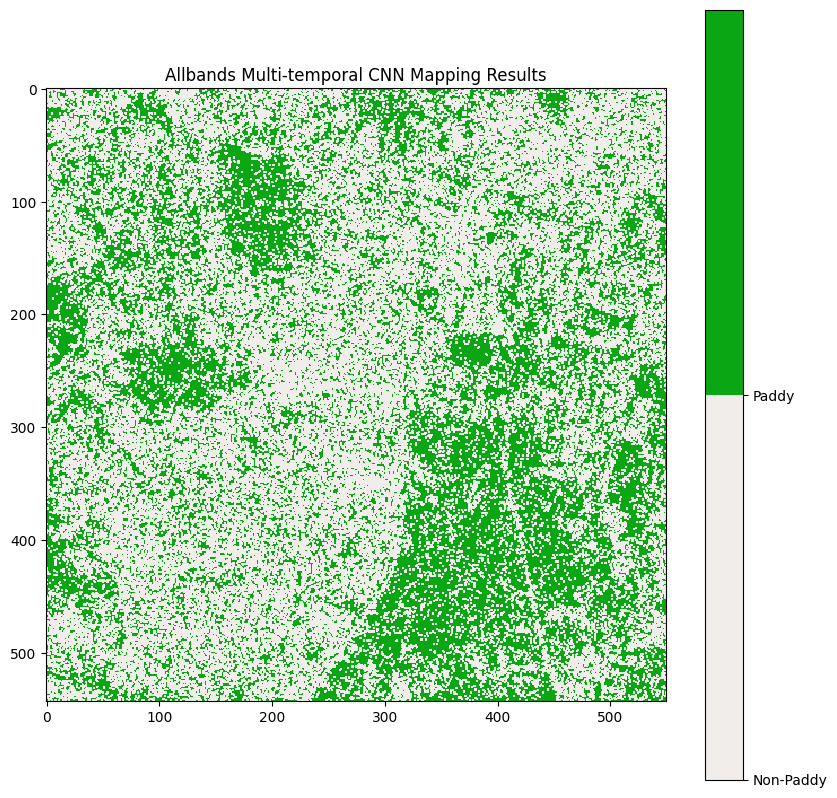

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(GlobalAveragePooling1D())
#cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 4')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allvi_new.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allvi_new.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allvi_new.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **Scheme #5: allbands+ndvi**

75/75 [==============================] - 0s 2ms/step
Training time: 3.930540084838867 seconds
Testing time: 0.06273460388183594 seconds
Total time: 3.993274688720703 seconds
              precision    recall  f1-score   support

         1.0       0.92      0.86      0.89       665
         2.0       0.95      0.97      0.96      1706

    accuracy                           0.94      2371
   macro avg       0.93      0.91      0.92      2371
weighted avg       0.94      0.94      0.94      2371

[[ 571   94]
 [  49 1657]]
Producer accuracy: [0.85864662 0.97127784]
User accuracy: [0.92096774 0.94631639]
Test accuracy: 0.9396878954027836
Overall accuracy: 0.9396878954027836
Kappa coefficient: 0.8474201612413288
Recall: 0.9396878954027836
Precision: 0.939206794942459
F1 score: 0.9390243902265346


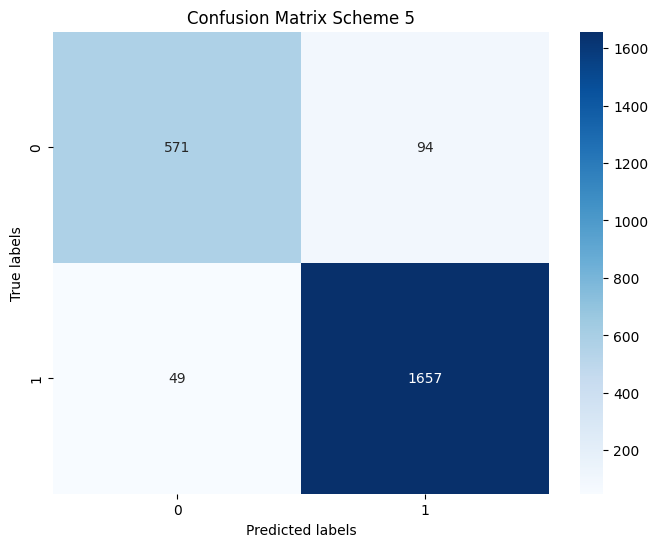

9333/9333 [==============================] - 26s 3ms/step


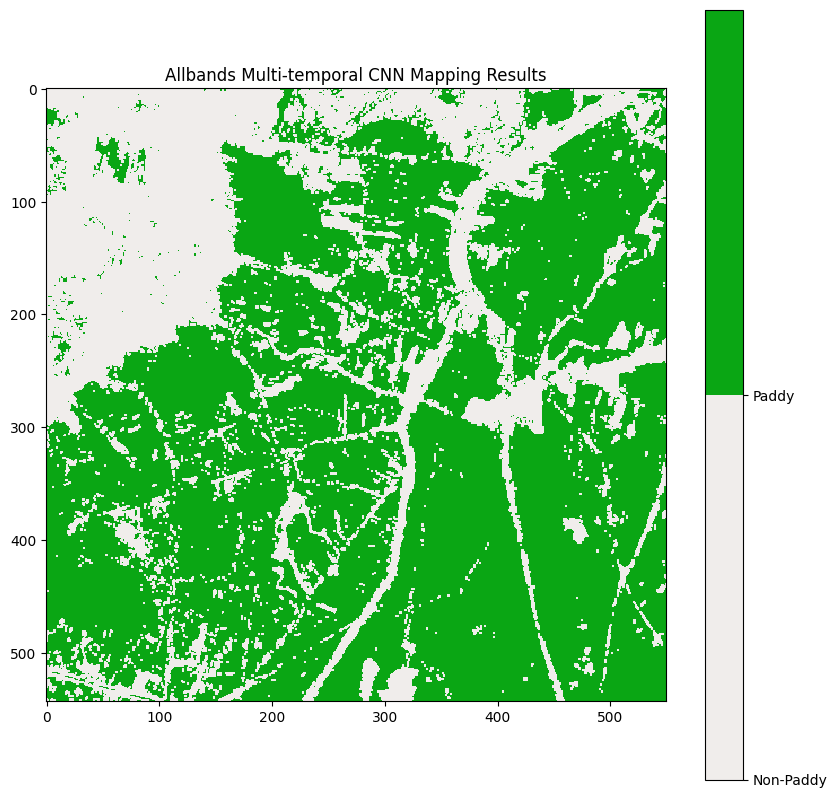

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+ndvi.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
#cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 4')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+ndvi.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+ndvi.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+ndvi.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **Scheme 6: allbands+evi**

75/75 [==============================] - 0s 2ms/step
Training time: 1.4309284687042236 seconds
Testing time: 0.05562305450439453 seconds
Total time: 1.4865515232086182 seconds
              precision    recall  f1-score   support

         1.0       0.69      0.36      0.47       665
         2.0       0.79      0.94      0.86      1706

    accuracy                           0.77      2371
   macro avg       0.74      0.65      0.66      2371
weighted avg       0.76      0.77      0.75      2371

[[ 238  427]
 [ 107 1599]]
Producer accuracy: [0.35789474 0.93728019]
User accuracy: [0.68985507 0.78923988]
Test accuracy: 0.774778574441164
Overall accuracy: 0.774778574441164
Kappa coefficient: 0.34596820017976504
Recall: 0.774778574441164
Precision: 0.7613651881466099
F1 score: 0.7487557280764658


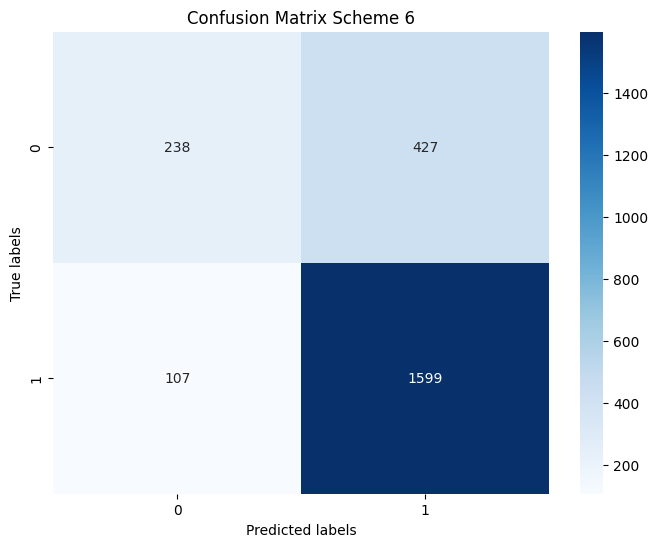

9333/9333 [==============================] - 13s 1ms/step


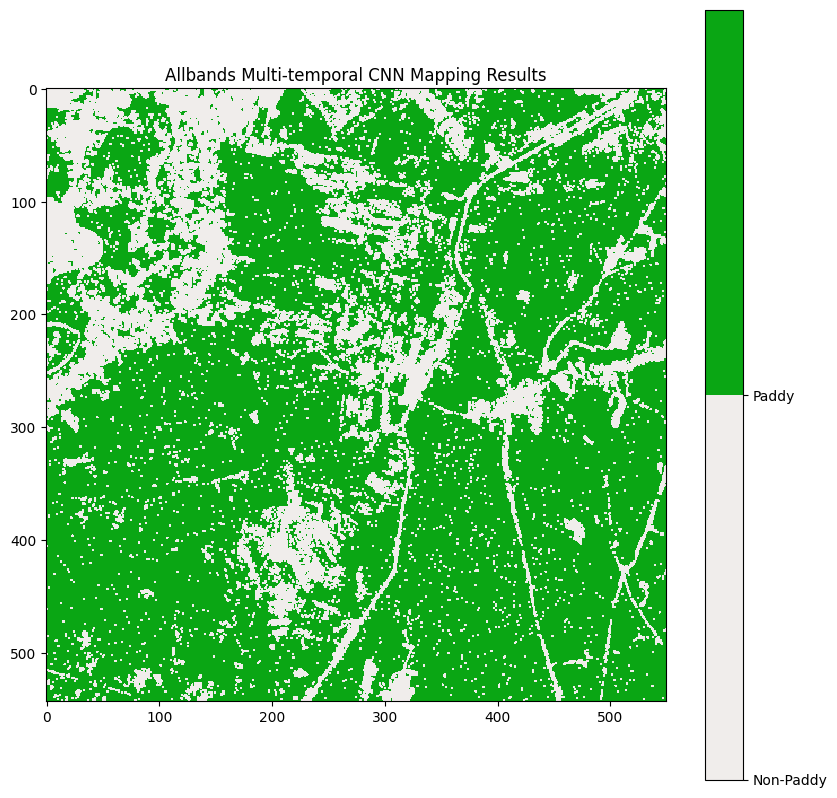

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+evi.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(GlobalAveragePooling1D())
#cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 6')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+evi.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+evi.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+evi.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **Scheme 7: allbands+lswi**

75/75 [==============================] - 0s 2ms/step
Training time: 4.162615537643433 seconds
Testing time: 0.061133623123168945 seconds
Total time: 4.223749160766602 seconds
              precision    recall  f1-score   support

         1.0       0.93      0.85      0.89       665
         2.0       0.94      0.98      0.96      1706

    accuracy                           0.94      2371
   macro avg       0.94      0.91      0.92      2371
weighted avg       0.94      0.94      0.94      2371

[[ 567   98]
 [  42 1664]]
Producer accuracy: [0.85263158 0.97538101]
User accuracy: [0.93103448 0.94438138]
Test accuracy: 0.9409531843104175
Overall accuracy: 0.9409531843104175
Kappa coefficient: 0.8498473775537345
Recall: 0.9409531843104175
Precision: 0.9406379474847077
F1 score: 0.9401321853267873


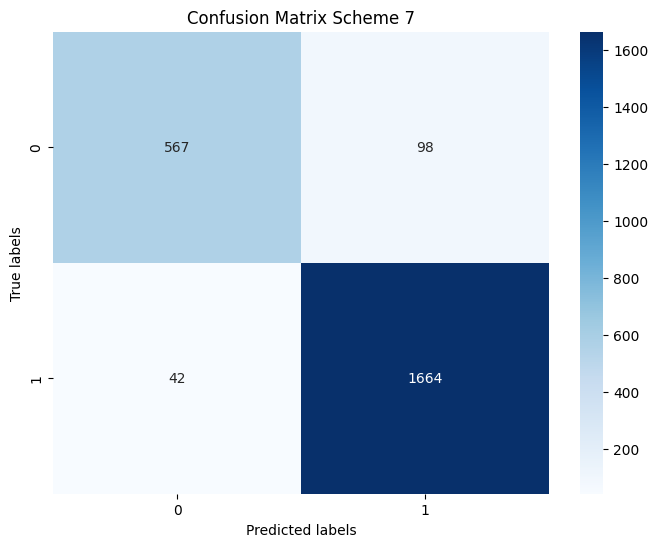

9333/9333 [==============================] - 20s 2ms/step


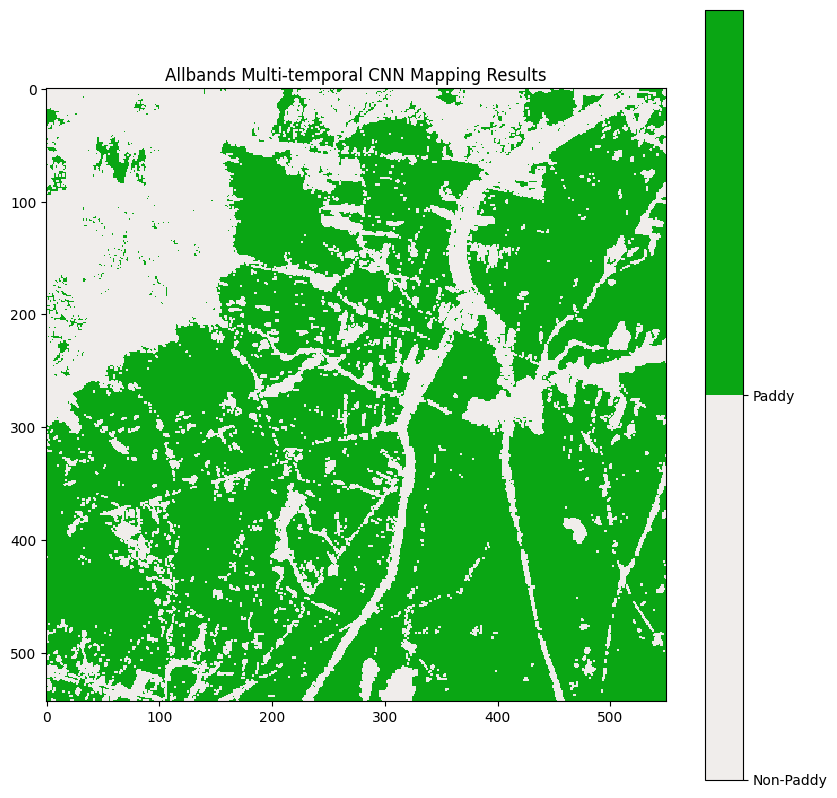

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+lswi.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
#cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 7')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+lswi.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+lswi.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+lswi.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **Scheme 8: allbands+rgvi**

75/75 [==============================] - 0s 3ms/step
Training time: 4.754564046859741 seconds
Testing time: 0.050460100173950195 seconds
Total time: 4.805024147033691 seconds
              precision    recall  f1-score   support

         1.0       0.93      0.86      0.89       665
         2.0       0.95      0.97      0.96      1706

    accuracy                           0.94      2371
   macro avg       0.94      0.92      0.93      2371
weighted avg       0.94      0.94      0.94      2371

[[ 573   92]
 [  44 1662]]
Producer accuracy: [0.86165414 0.97420868]
User accuracy: [0.9286872  0.94754846]
Test accuracy: 0.9426402361872628
Overall accuracy: 0.9426402361872628
Kappa coefficient: 0.8546848777744329
Recall: 0.9426402361872628
Precision: 0.9422583970061348
F1 score: 0.9419642896500559


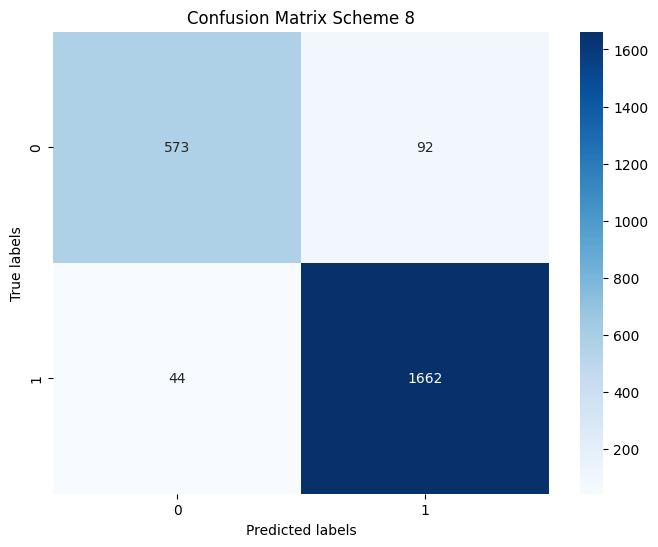

9333/9333 [==============================] - 20s 2ms/step


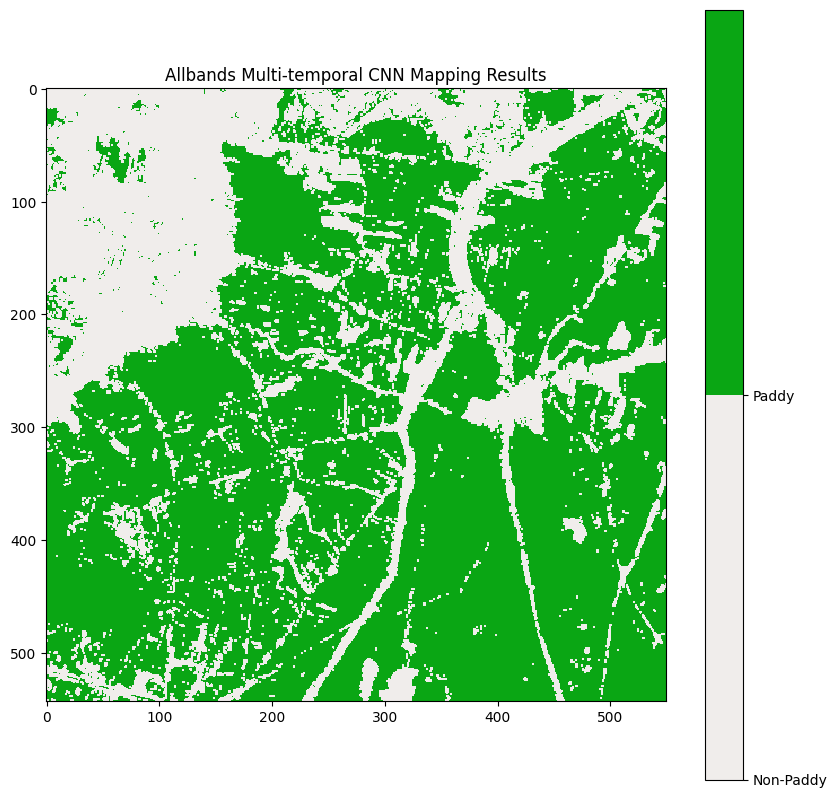

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+rgvi.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
#cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 8')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands+rgvi.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+rgvi.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands+rgvi.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()

# **scheme 9: allbands+allvi**

75/75 [==============================] - 0s 2ms/step
Training time: 5.225209474563599 seconds
Testing time: 0.06127572059631348 seconds
Total time: 5.286485195159912 seconds
              precision    recall  f1-score   support

         1.0       0.92      0.88      0.90       665
         2.0       0.95      0.97      0.96      1706

    accuracy                           0.95      2371
   macro avg       0.94      0.93      0.93      2371
weighted avg       0.94      0.95      0.94      2371

[[ 585   80]
 [  50 1656]]
Producer accuracy: [0.87969925 0.97069168]
User accuracy: [0.92125984 0.95391705]
Test accuracy: 0.9451708140025306
Overall accuracy: 0.9451708140025306
Kappa coefficient: 0.8622589654787175
Recall: 0.9451708140025306
Precision: 0.9447576059699929
F1 score: 0.9447771113819391


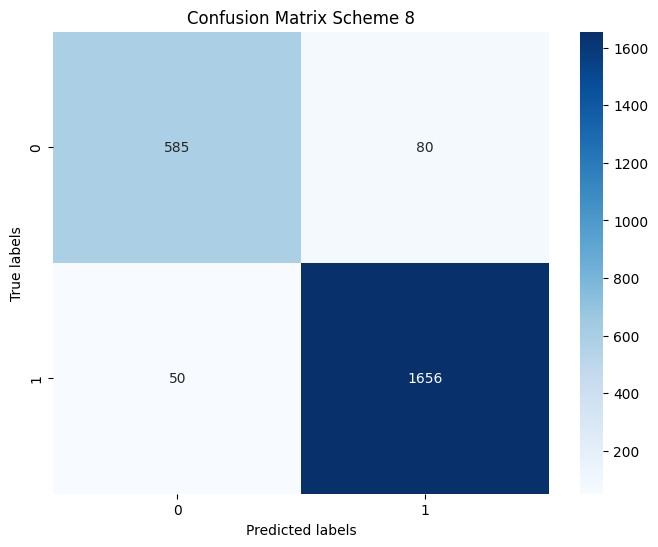

9333/9333 [==============================] - 22s 2ms/step


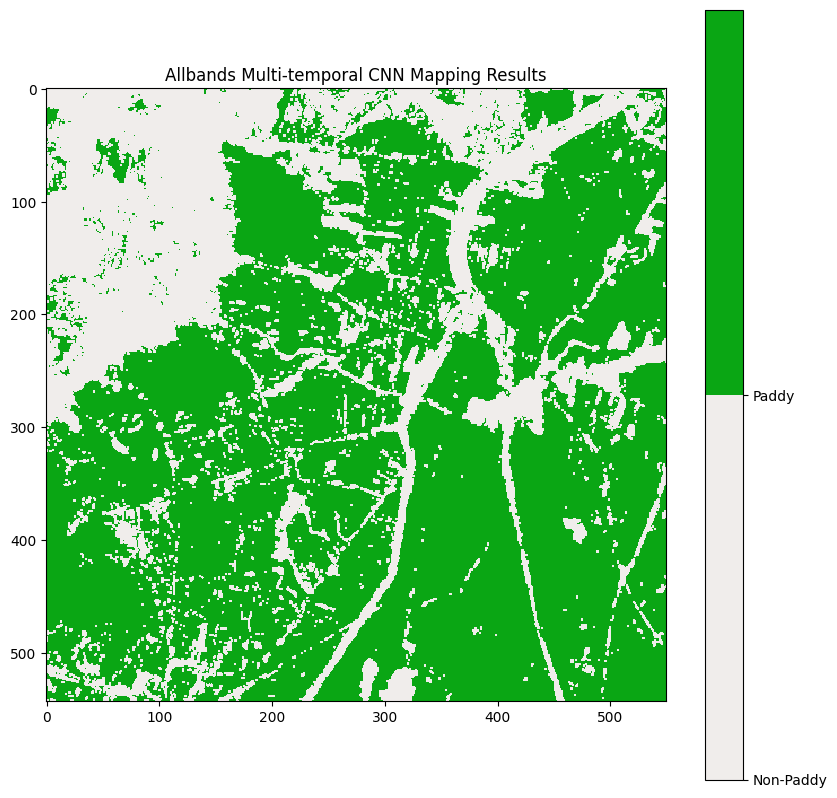

In [ ]:
# Load the Raw Bnad Spectral data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands_allvi.tif') as src:
    data = src.read()

# Load the training labels as a separate raster image for multiclass classification
with rasterio.open('/content/drive/MyDrive/Thesis/ground_truth.tif') as src:
    labels = src.read()

# Load the training labels as a separate raster image for binary classification
with rasterio.open('/content/drive/MyDrive/Thesis/pol_2class.tif') as src:
    labels2 = src.read()
# Flatten the stacked image data to 2D array
data = data.reshape(data.shape[0], -1).T

# Reshape ground truth data to 1D array
ground_truth = labels.reshape(-1)
ground_truth_binary = labels2.reshape(-1)
# Create a mask that selects only the pixels with ground truth value > 0
mask = np.where(ground_truth > 0)

data =  data[mask]
ground_truth = ground_truth[mask]
ground_truth_binary = ground_truth_binary[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, ground_truth_binary, test_size=0.3, random_state=42, stratify=ground_truth_binary)

# Define CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
#cnn_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.1))
#cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

#feature extration
X_train_cnn = cnn_model.predict(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)))
X_test_cnn = cnn_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# Define RF model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
start_time = time.time()
rf_model.fit(X_train_cnn, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Predict using RF
start_time = time.time()
y_pred = rf_model.predict(X_test_cnn)
end_time = time.time()


# Calculate testing time
testing_time = end_time - start_time
print(f"Testing time: {testing_time} seconds")

# Calculate total time
total_time = training_time + testing_time
print(f"Total time: {total_time} seconds")

# Print classification report
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate number of pixel in each category
total_pixels = np.sum(cm)

# Calculate parameter evaluation
test_acc = accuracy_score(y_test, y_pred)
overall_acc = np.sum(np.diag(cm)) / total_pixels
producer_acc = np.diag(cm) / np.sum(cm, axis=1)
user_acc = np.diag(cm) / np.sum(cm, axis=0)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print the results
print(f'Producer accuracy: {producer_acc}')
print(f'User accuracy: {user_acc}')
print(f"Test accuracy: {test_acc}")
print(f'Overall accuracy: {overall_acc}')
print(f'Kappa coefficient: {kappa}')
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")


#confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Scheme 8')
plt.savefig('S2_Band_CM.png')
plt.show()


# Load Sentinel-2 data
with rasterio.open('/content/drive/MyDrive/Thesis/allbands_allvi.tif') as src:
    s2_data = src.read()
    profile = src.profile

# Flatten the data array to a 2D numpy array (rows = pixels, columns = bands)
s2_data_2d = s2_data.reshape(s2_data.shape[0], -1).T

# Apply the CNN feature extraction
s2_data_cnn = cnn_model.predict(s2_data_2d.reshape((s2_data_2d.shape[0], s2_data_2d.shape[1], 1)))

# Use random forest models
s2_data_class = rf_model.predict(s2_data_cnn)

# Reshape the predicted class data to the original S2 shape
s2_data_class = s2_data_class.reshape(s2_data.shape[1], s2_data.shape[2])

# Save predicted classes as a raster TIFF file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands_allvi.tif', 'w', **profile) as dst:
    dst.write(s2_data_class.astype(rasterio.uint8), 1)

# Define the color map for each class
colors = ['#f0edeb', '#0aa614']
cmap = ListedColormap(colors)

# Open the predicted classes raster file
with rasterio.open('/content/drive/MyDrive/Thesis/CNN-RF/binary/S2Band_PredClass_allbands_allvi.tif') as src:
    predicted_classes = src.read(1)

# Plot the predicted classes raster
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(predicted_classes, cmap=cmap, norm=plt.Normalize(vmin=1, vmax=3))
cbar = fig.colorbar(im, ax=ax, ticks=range(1, 3))
cbar.ax.set_yticklabels([ 'Non-Paddy', 'Paddy'])
ax.set_title('Allbands Multi-temporal CNN Mapping Results')
plt.show()